In [40]:
#Import dependency
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from datetime import datetime
import requests
import psycopg2
import config as creds


In [41]:
def connect():
    
    # Set up a connection to the postgres server.
    conn_string = "host="+ creds.PGHOST +" port="+ "5432" +" dbname="+ creds.PGDATABASE +" user=" + creds.PGUSER \
                 +" password="+ creds.PGPASSWORD
    
    conn = psycopg2.connect(conn_string)
    #print("Connected!")

    #Create a cursor object
    cursor = conn.cursor()
    
    return conn, cursor


In [42]:
# Connecting to DB

conn, cursor = connect()

# SQL command to create inventory table
sql = "select * from ames;"
#cursor.execute(sql)
df = pd.read_sql_query(sql, conn)
#conn.commit()
# dat = pd.read_sql_query(sql, conn)


**Final Data Cleaning before importing the dataset into our model**

In [43]:
#Drop the ames_order, pid column since it doesn't help with prediction
df.drop(columns=["ames_order"], axis=1, inplace=True)
df.set_index(df['pid'],inplace=True)
df

,pid,mssubclass,mszoning,lotarea,street,lotshape,landcontour,lotconfig,landslope,neighborhood,...,3ssnporch,screenporch,poolarea,miscval,mosold,yrsold,saletype,salecondition,saleprice,total_area
pid,,,,,,,,,,,,,,,,,,,,,
526301100,526301100,20,RL,31770,Pave,IR1,Lvl,Corner,Gtl,NAmes,...,0,0,0,0,5,2010,WD,Normal,215000,4920
526350040,526350040,20,RH,11622,Pave,Reg,Lvl,Inside,Gtl,NAmes,...,0,120,0,0,6,2010,WD,Normal,105000,3404
526351010,526351010,20,RL,14267,Pave,IR1,Lvl,Corner,Gtl,NAmes,...,0,0,0,12500,6,2010,WD,Normal,172000,4299
526353030,526353030,20,RL,11160,Pave,Reg,Lvl,Corner,Gtl,NAmes,...,0,0,0,0,4,2010,WD,Normal,244000,6852
527105010,527105010,60,RL,13830,Pave,IR1,Lvl,Inside,Gtl,Gilbert,...,0,0,0,0,3,2010,WD,Normal,189900,4668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
923275080,923275080,80,RL,7937,Pave,IR1,Lvl,CulDSac,Gtl,Mitchel,...,0,0,0,0,3,2006,WD,Normal,142500,3597
923276100,923276100,20,RL,8885,Pave,IR1,Low,Inside,Mod,Mitchel,...,0,0,0,0,6,2006,WD,Normal,131000,3152
923400125,923400125,85,RL,10441,Pave,Reg,Lvl,Inside,Gtl,Mitchel,...,0,0,0,700,7,2006,WD,Normal,132000,2852


In [44]:
categorical = df.select_dtypes('object')
categorical.columns

Index(['pid', 'mssubclass', 'mszoning', 'street', 'lotshape', 'landcontour',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'overallqual', 'overallcond', 'roofstyle',
       'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype', 'exterqual',
       'extercond', 'foundation', 'heating', 'heatingqc', 'centralair',
       'electrical', 'kitchenqual', 'functional', 'paveddrive', 'saletype',
       'salecondition'],
      dtype='object')

In [45]:
numerical = df.select_dtypes(exclude='object')
numerical.columns

Index(['lotarea', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', '1stflrsf', '2ndflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', '3ssnporch', 'screenporch', 'poolarea',
       'miscval', 'mosold', 'yrsold', 'saleprice', 'total_area'],
      dtype='object')

**check if our data are normally distributed in order to be used in linear regression model**

In [46]:
#Check skewness of the dataset
from scipy.stats import skew 
skewness = numerical.apply(lambda x: skew(x))
skewness.sort_values(ascending=False)

miscval          21.358067
poolarea         16.432732
lotarea          12.990651
lowqualfinsf     12.131730
3ssnporch        11.343489
kitchenabvgr      4.220799
bsmtfinsf2        4.026744
enclosedporch     3.979661
screenporch       3.882597
bsmthalfbath      3.818322
openporchsf       2.660786
masvnrarea        2.474363
saleprice         1.837788
wooddecksf        1.824971
1stflrsf          1.513314
bsmtfinsf1        1.431787
total_area        1.357359
grlivarea         1.289576
totalbsmtsf       1.193826
bsmtunfsf         0.938686
2ndflrsf          0.914635
totrmsabvgrd      0.765231
halfbath          0.761664
fireplaces        0.725214
bsmtfullbath      0.616436
bedroomabvgr      0.303137
garagearea        0.266859
fullbath          0.238783
mosold            0.188568
yrsold            0.141621
garagecars       -0.175933
yearremodadd     -0.392857
yearbuilt        -0.559509
garageyrblt      -3.929012
dtype: float64

In [47]:
# #normalize the data by taking log
# skewness = np.log(skewness)
# skewness.sort_values(ascending=False)

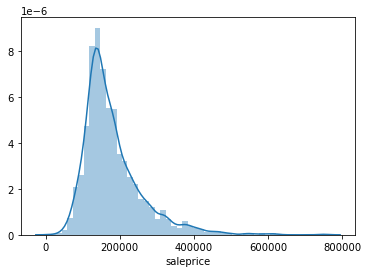

In [48]:
# check if saleprice is normally distributed in order to be used in our Multiple linear regression model later
sns.distplot(df['saleprice']);
#we can see the saleprice is right skewed

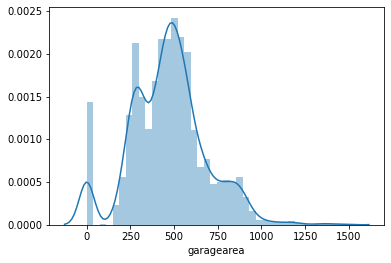

In [49]:
#check the distribution of garagearea
sns.distplot(df['garagearea']);

In [50]:
#dropping any NA before putting the dataset into our model
df = df.dropna()
df.isnull().sum()

pid              0
mssubclass       0
mszoning         0
lotarea          0
street           0
                ..
yrsold           0
saletype         0
salecondition    0
saleprice        0
total_area       0
Length: 66, dtype: int64

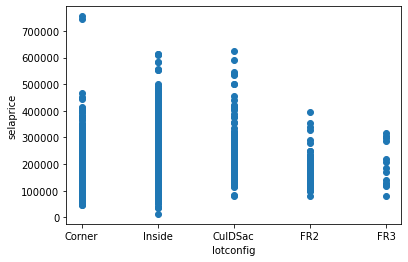

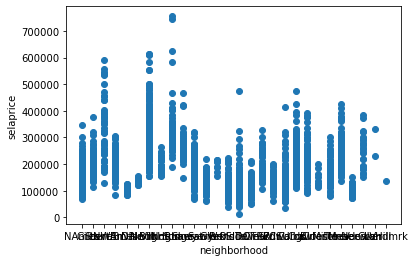

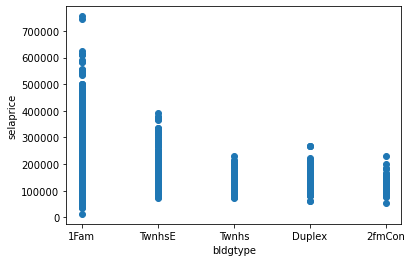

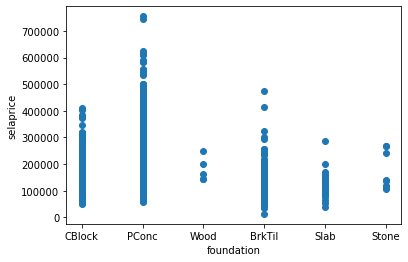

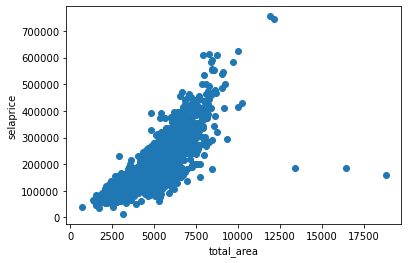

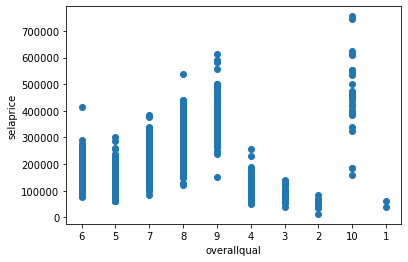

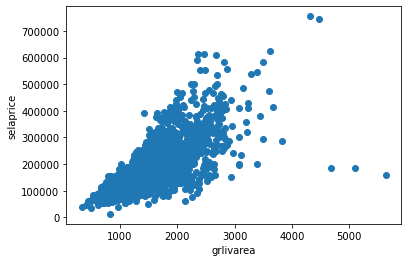

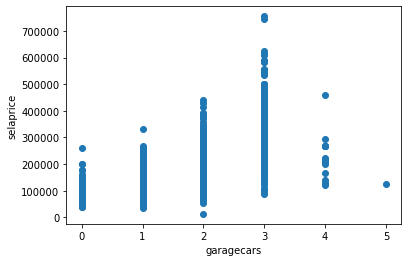

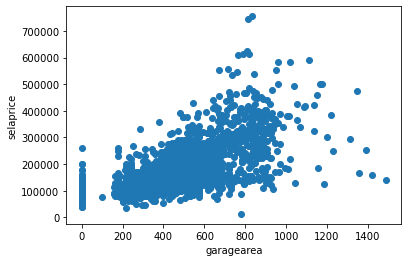

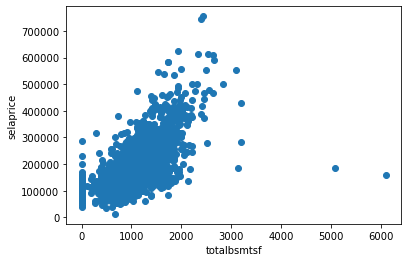

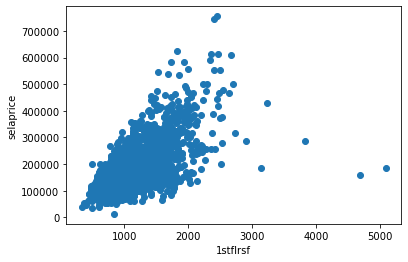

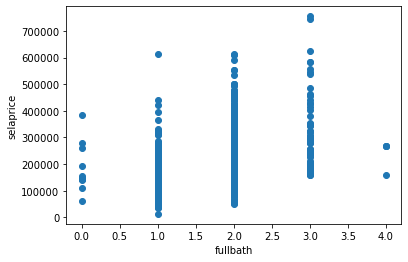

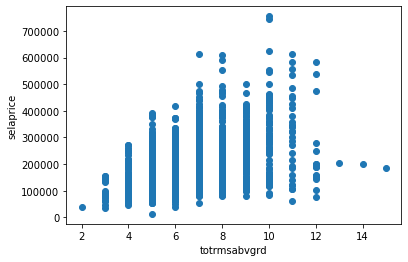

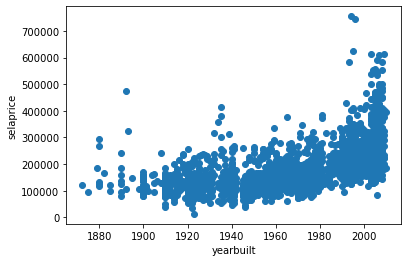

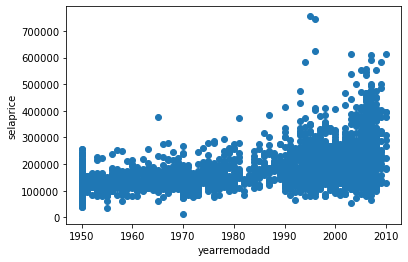

In [51]:
#See the relationship between selected features and target
x_features = ["lotconfig", "neighborhood", "bldgtype", "foundation","total_area","overallqual","grlivarea", "garagecars","garagearea","totalbsmtsf","1stflrsf","fullbath","totrmsabvgrd", "yearbuilt","yearremodadd"]
for x in x_features:

  plt.scatter(df[x], df['saleprice'])
  plt.xlabel(x)
  plt.ylabel('selaprice')
  plt.show()

# **Initial Features Selection**
we selected 15 features.

***NUmerical Category:***
Based on heatmap, pick the top 11 features that are most correlated to sales price(vmax>0.5). We also added another additional features: total_area

* overallqual
* grlivarea	
* garagecars
* garagearea
* totalbsmtsf	
* 1stflrsf
* fullbath	
* totrmsabvgrd
* yearbuilt	
* yearremodadd
* ADDED total_area

***Categorical Category:***
Categorical object can not be compared using heatmap so we selected a few more features based on commonsense
* lotconfig
* neighborhood
* bldgtype
* foundation


**Use Label Encoder to to transform categorical features**

In [52]:
#Convert numerical categories that shouldn't be numerical to categorical categories
#please refer to the description file for definition of each category
df['mssubclass'] = df['mssubclass'].astype(str)
df['yrsold'] = df['yrsold'].astype(str)
df['mosold'] = df['mosold'].astype(str)
df['overallcond'] = df['overallcond'].astype(str)
df['overallqual'] = df['overallqual'].astype(str)
df.dtypes

pid              object
mssubclass       object
mszoning         object
lotarea           int64
street           object
                  ...  
yrsold           object
saletype         object
salecondition    object
saleprice         int64
total_area        int64
Length: 66, dtype: object

In [58]:
#transform text into numerical data by applying LabelEncoder 
from sklearn.preprocessing import LabelEncoder
cols = ['mssubclass', 'mszoning', 'street', 'lotshape', 'landcontour',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'salecondition',
       'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype', 'exterqual',
       'extercond', 'foundation', 'heating', 'heatingqc', 'centralair',
       'electrical', 'kitchenqual', 'functional', 'paveddrive', 'saletype','overallcond', 'overallqual','yrsold', 'mosold']


# # Label Encoder DataFrame for neighborhood columns
# le = LabelEncoder()
# df2 = df[['neighborhood']].copy(())
# df2['neighborhood_encoded'] = le.fit_transform(list(df['neighborhood'].values))

# print(df2.neighborhood_encoded.unique())
# print(df2.neighborhood.unique())

# Code = [15,8,25,17,2,16,19,0,18,24,23,22,9,3,20,11,4,21,7,5,6,1,14,26,13,27,10,12]
# Name = ['NAmes', 'Gilbert', 'StoneBr', 'NWAmes', 'BrDale', 'NPkVill', 'NridgHt',
#  'Blmngtn', 'NoRidge', 'Somerst', 'SawyerW', 'Sawyer', 'Greens', 'BrkSide', 
# 'OldTown', 'IDOTRR', 'ClearCr', 'SWISU', 'Edwards', 'CollgCr', 'Crawfor',
#  'Blueste', 'Mitchel', 'Timber', 'MeadowV', 'Veenker', 'GrnHill', 'Landmrk']

# df_neighborhood = pd.DataFrame(Code, Name, columns=['Label Encoder'])
# df_neighborhood

# le = LabelEncoder()
# df2 = df[['yrsold']].copy(())
# df2['yrsold_encoded'] = le.fit_transform(list(df['yrsold'].values))

# print(df2.yrsold_encoded.unique())
# print(df2.yrsold.unique())

# Code = [4,3,2,1,0]
# Name = ['2010', '2009', '2008', '2007', '2006']
# df_yrsold = pd.DataFrame(Code, Name, columns=['Label Encoder'])
# df_yrsold


# le = LabelEncoder()
# df2 = df[['overallqual']].copy(())
# df2['overallqual_encoded'] = le.fit_transform(list(df['overallqual'].values))

# print(df2.overallqual_encoded.unique())
# print(df2.overallqual.unique())

# Code = [6, 5, 7, 8, 9, 4, 3, 2, 1, 0]
# Name = ['6', '5', '7', '8', '9', '4', '3', '2', '10', '1']
# df_overallqual = pd.DataFrame(Code, Name, columns=['Label Encoder'])
# df_overallqual

values = []

for col in cols:
    
    names = df[col].unique
    print(f"names = {names}")
  
    le = LabelEncoder()
    le.fit(list(df[col].values))
    numbers = le.fit_transform(list(df[col].values))
    df[col] = numbers
    
    values.append({"names": names, "numbers": numbers})
    


names = <bound method Series.unique of pid
526301100    20
526350040    20
526351010    20
526353030    20
527105010    60
             ..
923275080    80
923276100    20
923400125    85
924100070    20
924151050    60
Name: mssubclass, Length: 2762, dtype: object>
names = <bound method Series.unique of pid
526301100    RL
526350040    RH
526351010    RL
526353030    RL
527105010    RL
             ..
923275080    RL
923276100    RL
923400125    RL
924100070    RL
924151050    RL
Name: mszoning, Length: 2762, dtype: object>
names = <bound method Series.unique of pid
526301100    Pave
526350040    Pave
526351010    Pave
526353030    Pave
527105010    Pave
             ... 
923275080    Pave
923276100    Pave
923400125    Pave
924100070    Pave
924151050    Pave
Name: street, Length: 2762, dtype: object>
names = <bound method Series.unique of pid
526301100    IR1
526350040    Reg
526351010    IR1
526353030    Reg
527105010    IR1
            ... 
923275080    IR1
923276100    IR1
9234001

# **Step 4: Multiple Linear Regression Model: Predict house prices based on the selected features**
* Set x and y
* Scale x and y
* Split the data into train and test (X:features, y=target)
* Create an instance of the model with model = LinearRegression().
* Train the model with the dataset with model.fit(X,y)
* Create predictions with y_pred = model.predict(X)


In [15]:
#put our selected features into a list

cols_8 = ["neighborhood","total_area","overallqual", "garagecars","fullbath","yearbuilt","yearremodadd","yrsold"]


#assign y to our target and x to our features 

y = df['saleprice'].values
X = df[cols_8]



In [16]:
X

,neighborhood,total_area,overallqual,garagecars,fullbath,yearbuilt,yearremodadd,yrsold
pid,,,,,,,,
526301100,15,4920,6,2,1,1960,1960,4
526350040,15,3404,5,1,1,1961,1961,4
526351010,15,4299,6,1,1,1958,1958,4
526353030,15,6852,7,2,2,1968,1968,4
527105010,8,4668,5,2,2,1997,1998,4
...,...,...,...,...,...,...,...,...
923275080,14,3597,6,2,1,1984,1984,0
923276100,14,3152,5,2,1,1983,1983,0
923400125,14,2852,5,0,1,1992,1992,0


Perform 80/20 data split

In [17]:
#data is split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 0)
#check the shape of each set
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2209, 8), (553, 8), (2209,), (553,))

In [18]:
# Reshape the y values and then print them out
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
print(y_train.shape)
print(y_test.shape)

(2209, 1)
(553, 1)


In [19]:
# Define a scaler for the X values and the y values and fit them to the training set
X_scaler = preprocessing.StandardScaler().fit(X_train)


# Scale the training set and the testing set using the new scalers
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


#Take a log of the target to make it more normally distributed
y_train_scaled = np.log(y_train)
y_test_scaled = np.log(y_test)

**Fit data to our Multiple Linear Regression Model**

In [20]:
#define the model
model = linear_model.LinearRegression()
#build training model --> time start time 
start=datetime.now()

# Fit the model to the scaled training set
model.fit(X_train_scaled, y_train_scaled)

#time the end time
end=datetime.now()

#run prediction on scaled test set 
y_test_pred = model.predict(X_test_scaled)



In [21]:
# Export our model 

from joblib import dump, load
dump(model, 'mlr_model.joblib') 


['mlr_model.joblib']

In [22]:
#print the coefficient, intercept, MSE and model score(R^2),and model run time
print(f"Coefficients: {model.coef_}")
print(f"Intercept: {model.intercept_}")
print(f"Mean squared Error(MSE): {mean_squared_error(y_test_scaled, y_test_pred):.2f}")
print(f"Coefficient of Determination(R^2): {r2_score(y_test_scaled, y_test_pred):.2f}")
time_taken = end - start
print(f"Time to run the model: {time_taken}")


Coefficients: [[ 0.00428309  0.21215925  0.09526144  0.03506679 -0.01836104  0.06779652
   0.05328184 -0.0076852 ]]
Intercept: [12.01627885]
Mean squared Error(MSE): 0.03
Coefficient of Determination(R^2): 0.86
Time to run the model: 0:00:00.002992


In [23]:
y_test = pd.DataFrame(y_test)
y_test_pred = np.exp(y_test_pred)
y_test_pred = pd.DataFrame(y_test_pred)
y_test, y_test_pred


(          0
 0    177000
 1    230500
 2    215700
 3    203000
 4    234250
 ..      ...
 548  148000
 549  136870
 550  178000
 551  158000
 552  268500
 
 [553 rows x 1 columns],
                  0
 0    135090.828291
 1    251788.187970
 2    194295.773528
 3    256493.476306
 4    220390.333194
 ..             ...
 548  129498.842023
 549  123914.502238
 550  170759.828023
 551  184191.657734
 552  283448.050776
 
 [553 rows x 1 columns])


**Formula for our multiple linear regression model**

y = -2.67021895e-16 + 0.03896429*neighborhood + 0.60886396*total_area + 0.13411633*overallqual + 0.08067865*garagecars + (-0.07035814*fullbath) + 0.16385461*yearbuilt +0.12970701*yearremodadd +(-0.01437204*yrsold) 

**An example of how we get the result for different number of features**

In [24]:
# cols_64 = ['mssubclass', 'mszoning', 'lotarea', 'street', 'lotshape',
#        'landcontour', 'lotconfig', 'landslope', 'neighborhood', 'condition1',
#        'condition2', 'bldgtype', 'housestyle', 'overallqual', 'overallcond',
#        'yearbuilt', 'yearremodadd', 'roofstyle', 'roofmatl', 'exterior1st',
#        'exterior2nd', 'masvnrtype', 'masvnrarea', 'exterqual', 'extercond',
#        'foundation', 'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf',
#        'heating', 'heatingqc', 'centralair', 'electrical', '1stflrsf',
#        '2ndflrsf', 'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath',
#        'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'kitchenqual',
#        'totrmsabvgrd', 'functional', 'fireplaces', 'garageyrblt', 'garagecars',
#        'garagearea', 'paveddrive', 'wooddecksf', 'openporchsf',
#        'enclosedporch', '3ssnporch', 'screenporch', 'poolarea', 'miscval',
#        'mosold', 'yrsold', 'saletype', 'salecondition','total_area']
# cols_54 = [
#        'condition2', 'bldgtype', 'housestyle', 'overallqual', 'overallcond',
#        'yearbuilt', 'yearremodadd', 'roofstyle', 'roofmatl', 'exterior1st',
#        'exterior2nd', 'masvnrtype', 'masvnrarea', 'exterqual', 'extercond',
#        'foundation', 'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf',
#        'heating', 'heatingqc', 'centralair', 'electrical', '1stflrsf',
#        '2ndflrsf', 'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath',
#        'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'kitchenqual',
#        'totrmsabvgrd', 'functional', 'fireplaces', 'garageyrblt', 'garagecars',
#        'garagearea', 'paveddrive', 'wooddecksf', 'openporchsf',
#        'enclosedporch', '3ssnporch', 'screenporch', 'poolarea', 'miscval',
#        'mosold', 'yrsold', 'saletype', 'salecondition','total_area']
# cols_44 = [
#        'condition2', 'bldgtype', 'housestyle', 'overallqual', 'overallcond',
#        'yearbuilt', 'yearremodadd', 'roofstyle', 'roofmatl', 'exterior1st',
#        'heating', 'heatingqc', 'centralair', 'electrical', '1stflrsf',
#        '2ndflrsf', 'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath',
#        'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'kitchenqual',
#        'totrmsabvgrd', 'functional', 'fireplaces', 'garageyrblt', 'garagecars',
#        'garagearea', 'paveddrive', 'wooddecksf', 'openporchsf',
#        'enclosedporch', '3ssnporch', 'screenporch', 'poolarea', 'miscval',
#        'mosold', 'yrsold', 'saletype', 'salecondition','total_area']
# cols_34 = [
#        'overallqual', 'overallcond',
#        'yearbuilt', 'yearremodadd', '1stflrsf',
#        '2ndflrsf', 'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath',
#        'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'kitchenqual',
#        'totrmsabvgrd', 'functional', 'fireplaces', 'garageyrblt', 'garagecars',
#        'garagearea', 'paveddrive', 'wooddecksf', 'openporchsf',
#        'enclosedporch', '3ssnporch', 'screenporch', 'poolarea', 'miscval',
#        'mosold', 'yrsold', 'saletype', 'salecondition','total_area']
# cols_24 = [
#        'overallqual', 'overallcond',
#        'yearbuilt', 'yearremodadd', '1stflrsf',
#        '2ndflrsf', 'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath',
#        'fullbath', 'halfbath', 'garagecars',
#        'garagearea', 
#        'enclosedporch', '3ssnporch', 'screenporch', 'poolarea', 'miscval',
#        'mosold', 'yrsold', 'saletype', 'salecondition','total_area']

# cols_15 = ["total_area","overallqual","grlivarea", "garagecars","garagearea","totalbsmtsf","1stflrsf","fullbath","totrmsabvgrd", "yearbuilt","yearremodadd"]

# cols_11 = ["lotconfig", "neighborhood", "bldgtype", "foundation","total_area","overallqual","totrmsabvgrd", "yearbuilt","yearremodadd"]

# cols_8 = ["neighborhood","total_area","overallqual", "garagecars","fullbath","yearbuilt","yearremodadd","yrsold"]

# n = [cols_64,cols_54,cols_44,cols_34,cols_24, cols_15, cols_11, cols_8]
# #assign y to our target and x to our features 

# for i in n:
#     y = df['saleprice'].values
#     X = df[i]
#     #data is split into training and testing sets
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 0)
#     #check the shape of each set
#     X_train.shape, X_test.shape, y_train.shape, y_test.shape
#     print(X_train.shape)
#     # Define a scaler for the X values and the y values and fit them to the training set
#     X_scaler = preprocessing.StandardScaler().fit(X_train)


#     # Scale the training set and the testing set using the new scalers
#     X_train_scaled = X_scaler.transform(X_train)
#     X_test_scaled = X_scaler.transform(X_test)



#     y_train_scaled = np.log(y_train)
#     y_test_scaled = np.log(y_test)

#     # Reshape the y values and then print them out
#     y_train = y_train.reshape(-1, 1)
#     y_test = y_test.reshape(-1, 1)

#     #define the model
#     model = linear_model.LinearRegression()
#     #build training model --> time start time 
#     start=datetime.now()

#     # Fit the model to the scaled training set
#     model.fit(X_train_scaled, y_train_scaled)

#     #time the end time
#     end=datetime.now()

#     #run prediction on scaled test set 
#     y_test_pred = model.predict(X_test_scaled)

#     #print the coefficient, intercept, MSE and model score(R^2),and model run time
#     print(f"Coefficients: {model.coef_}")
#     print(f"Intercept: {model.intercept_}")
#     print(f"Mean squared Error(MSE): {mean_squared_error(y_test_scaled, y_test_pred):.2f}")
#     print(f"Coefficient of Determination(R^2): {r2_score(y_test_scaled, y_test_pred):.2f}")
#     time_taken = end - start
#     print(f"Time to run the model: {time_taken}")
    
    

(2209, 64)
Coefficients: [ 1.22774856e-02 -2.30442940e-02  9.72088254e-03  4.51341193e-03
 -8.60965240e-03  6.32325347e-03  2.26323342e-03  1.35764914e-02
  2.35732326e-03 -2.73009979e-03 -1.76340131e-03 -1.50643929e-02
 -1.41471680e-02  7.01073064e-02  5.55911168e-02  6.06661889e-02
  1.54182295e-02  6.22985900e-03  5.74647988e-03 -1.76240900e-02
  1.61438059e-02  7.70051485e-03  1.13453184e-02 -3.26185735e-02
  1.13757110e-02  5.82074531e-03  1.12802644e+11  4.22084832e+10
  1.06611410e+11  1.14575948e+11 -3.18578104e-04 -1.14294906e-02
  1.69073244e-02 -1.75204849e-03  4.45575585e+11  4.83605746e+11
  2.85298234e+10 -6.32920101e+10  2.66527162e-02  2.89740688e-03
  1.72376757e-02  2.94361432e-03 -7.33265275e-03 -1.78973158e-02
 -1.74486707e-02  1.03752102e-02  1.85510429e-02  2.60062186e-02
 -1.81286122e-03  5.39121051e-02  1.06998380e+11  1.62524421e-02
  8.09550318e-03  2.17394641e-04  1.25751227e-02  2.08923687e-03
  1.80449620e-02 -4.89223662e-03 -1.87871457e-02  8.15394475e-03


In [ ]:
#Compare with Deep Learning Model
nn_model = tf.keras.models.Sequential()

nn_model.add(tf.keras.layers.Dense(units=len(X.columns) * 2, activation = "relu", input_dim = len(X.columns)))
nn_model.add(tf.keras.layers.Dense(units=1, activation="linear"))
nn_model.summary()
nn_model.compile(loss="mean_squared_error", optimizer="adam")
#time starting time
start_1=datetime.now()

nn_model.fit(X_train_scaled, y_train_scaled, epochs=100)
#time ending time
end_1=datetime.now()

y_train_pred = nn_model.predict(X_train_scaled)
y_test_pred = nn_model.predict(X_test_scaled)



In [ ]:
# Evaluate the performance of the neural network
print(f"R^2 for training set: {r2_score(y_train_scaled, y_train_pred):.2f}")
print(f"R^2 for testing set: {r2_score(y_test_scaled, y_test_pred):.2f}")


In [ ]:
deep_model = tf.keras.models.Sequential()
deep_model.add(tf.keras.layers.Dense(units=len(X.columns) * 2, activation = "relu", input_dim = len(X.columns)))
deep_model.add(tf.keras.layers.Dense(units=len(X.columns) * 2, activation = "relu"))
deep_model.add(tf.keras.layers.Dense(units=1, activation="linear"))
deep_model.summary()

deep_model.compile(loss="mean_squared_error", optimizer="adam")
#start deep learning starting time
start_2=datetime.now()
deep_model.fit(X_train_scaled, y_train_scaled, epochs=100)
#time deep learning ending time
end_2=datetime.now()
y_train_pred = deep_model.predict(X_train_scaled)
y_test_pred = deep_model.predict(X_test_scaled)

In [ ]:
# Evaluate the performance and run time of the deep learning model
print(f"R^2 for training set: {r2_score(y_train_scaled, y_train_pred):.2f}")
print(f"R^2 for testing set: {r2_score(y_test_scaled, y_test_pred):.2f}")
time_taken_neu = end_1 - start_1
time_taken_dl = end_2 - start_2
total_time = time_taken_dl + time_taken_neu
print(f"Time to run the model: {total_time}")

In [ ]:
sns.pairplot(df, x_vars=["neighborhood","total_area","overallqual", "garagecars"], y_vars='saleprice', size=13, aspect=0.7, kind='reg')

In [ ]:
sns.pairplot(df, x_vars=["fullbath","yearbuilt","yearremodadd","yrsold"], y_vars='saleprice', size=13, aspect=0.7, kind='reg')


In [ ]:
#graph the relationship between y_test and t_test_pred
plt.scatter(y_test, y_test_pred)
plt.show()


In [ ]:
y_test_pred = model.predict(X_test_scaled)
#Plots predicted values against actual values in the train/test split.
plt.figure(figsize=(10,8))
plt.scatter(np.exp(y_test_pred),y_test,marker = '+')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')

#Plots x=y line
plt.plot([0,np.max(y_test)],[0,np.max(y_test)], c = 'k');

# Models Comparison


**Comparing Multiple Linear Regression VS Deep Learning in terms of model running time**

In [ ]:
#import the recording of the model run time and model result
data = pd.read_csv('Resources/run_time_r2.csv')
data = data.dropna()
data

In [ ]:
Features = ["8", "15"]
x = ['MLR', 'DL']
y = [0.02, 12.38]
plt.bar(x,y)

**Comparing Multiple Linear Regression VS Deep Learning in terms of R^2**

In [ ]:
x = data.Features
MLR = data['MLR_R^2']
DL = data['DL_R^2']
fig, ax = plt.subplots()
ax.plot(x,MLR, label='MLR')
ax.plot(x,DL, label='DL')
ax.set_title("Multiple Linear Regression VS Deep Learning")
ax.set_xlabel("Number of Features")
ax.set_ylabel("R^2 for Testing Set ")
ax.legend()

In [ ]:
#Other
# X_scaler.scale_
# X_scaler.inverse_transform
# y_test_pred = np.exp(y_test_pred)
# X_scaler.inverse_transform